# Monte Carlo methods and finite size analysis in paramagnetic-ferromagnetic models of phase transitions
## Laboratory of Computational Physics - 2021/2022
## Group 18 
Agosti Luca: *luca.agosti@studenti.unipd.it*  
Ballout Fatima: *fatima.ballout@studenti.unipd.it*  
Bee Nicola: *nicola.bee.1@studenti.unipd.it*  
Saccaro Lorenzo: *lorenzo.saccaro@studenti.unipd.it*


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm
import numba as nb
from scipy import optimize, stats
from IPython.display import display, Math

plt.rcParams['figure.figsize']=(8,8)
colab = False # set this if you are running the notebook on colab

In [2]:
if colab:

    !pip install numba --upgrade
    nb.set_num_threads(2)


# INTRODUCTION: Ising model and Monte Carlo simulation

## Ising Model
The Ising model is a simple, classical lattice model of a ferromagnet. In its usal formulation is defined in terms of a lattice of particles having spins with two possible values: $\sigma_i =\lbrace +1, -1 \rbrace$.

The 2D-Ising model allows the identification of a  phase transition and own an analytical description, made by Onsager in 1944.

The Hamiltonian of the system can be written as:
$$ H = - J \sum_{\langle jk\rangle}  \sigma_j \sigma_k - h \sum_j \sigma_j$$
where $\langle jk\rangle$ indicate that $i$ and $j$ are nearest neighbour.
The constant $h$ refers to an external magnetic field, while $J$ describe the interaction between spins; when $J>0$ the system is called ferromagnetic.

In this report we set $J=1$ and $h=0$. The Boltzman constant was set to $k_B=1$, too.


In [3]:
## PHYSICAL CONSTANTS ##

# to show first example (initial transient)
BETA = 0.2 #[J/K] beta = 1/k_b T  
L = 50  # Size of the system


CONTINUOUS = True
START = 'cold'
P_HOT = 0.75  # Probabilty of having spin UP = 1 in hot start 
J = 1.0 # [Joule] J > 0 if ferromagnetic, J < 0 if antiferromagnetic
BETA_C = np.log(1+np.sqrt(2))/ (2 * J) # Critical beta

## COMPUTATIONL PARAMETERS ##

SEED = 24012020
np.random.seed(SEED)  # Sets the seed for the RNG

N_THREADS = 8 # set this according to cpu/memory of your system (expect ~2GB of RAM per thread)

if not colab:    
    nb.set_num_threads(N_THREADS) # set number of thread for parallel computation where implemented 

#beta_range
BETA_STEPS= 30 
BETA_START = 1e-3
BETA_END = 1.2
BETA_CENTER_LOW = 0.3
BETA_CENTER_HIGH = 0.55
# more data points near the critical value
BETA_RANGE = np.concatenate((np.linspace(BETA_START,BETA_CENTER_LOW,int(BETA_STEPS/5), endpoint=False), 
                            np.linspace(BETA_CENTER_LOW,BETA_CENTER_HIGH,int(3*BETA_STEPS/5), endpoint=False),
                            np.linspace(BETA_CENTER_HIGH,BETA_END,int(BETA_STEPS/5), endpoint=True)))


#L range (size of the lattice)
L_STEPS = 30
L_START = 5
L_END = 200
L_RANGE = np.linspace(L_START,L_END,L_STEPS, dtype=np.int32)

# montecarlo steps
M_STEPS = int(1e8) 

#tau_range (for correlation coefficient study)
TAU_STEPS = 30
TAU_RANGE = np.logspace(0, int(np.log10(M_STEPS)-2), TAU_STEPS) # to have atleast 90+ data points



### Onsager Functions
According to Onsager's exact solution, the phase transition occurs at a critical temperature
$$T_C = \frac{2J}{k_B\ln(1+\sqrt{2})} $$

The total magnetization of the system at a given temperature $T < T_C$ is:
$$\langle m\rangle = \lbrace 1-\left[ \sinh(\frac{2J}{k_B T})\right]^{-4}\rbrace^{\frac{1}{8}} $$

While the heat capacity for a given $T < T_C$ is:
$$C=\frac{2k_B}{\pi}\left( \frac{2J}{k_BT_C}\right)^2 \left[ -\ln (1 - \frac{T}{T_C}) + ln(\frac{k_BT_C}{2J}) - (1+\frac{\pi}{4})\right] $$


In [4]:
# Compute the theorical magnetization given the beta
def mag_Onsager(dim, beta, J):
  
  k = 1.  # set S-B constant to one
  T_min = 1/(k*np.max(beta))
  T_max = 1/(k*np.min(beta))
  T = np.linspace(T_min, T_max, dim)
  
  T_C = 2 * J / (k * np.log(1+np.sqrt(2)))
  m = np.zeros_like(T)
  m[(T < T_C)] = ( 1 - np.sinh(2 * J / ( k * T[T<T_C]) )**(-4) )**(0.125)
  
  
  b = 1/ (k * T)

  return m, b

In [5]:
# Compute the theorical specific heat given the beta
def C_Onsager(dim, beta, J):
  
    k = 1.  # set S-B constant to one
    T_min = 1/(k*np.max(beta))
    T_max = 1/(k*np.min(beta))
    T = np.linspace(T_min, T_max, dim)
    
    T_C = 2 * J / (k * np.log(1+np.sqrt(2)))
    pi = np.pi
    C = np.zeros_like(T)
    C[(T < T_C)] = ( 2 * k / pi ) * (2 * J / (k * T_C))**2 * ( -1*np.log( 1 - T[(T<T_C)]/T_C ) + np.log(k * T_C / ( 2 * J )) - (1 + pi/4 ))
    

    b = 1/ (k * T)

    return C, b

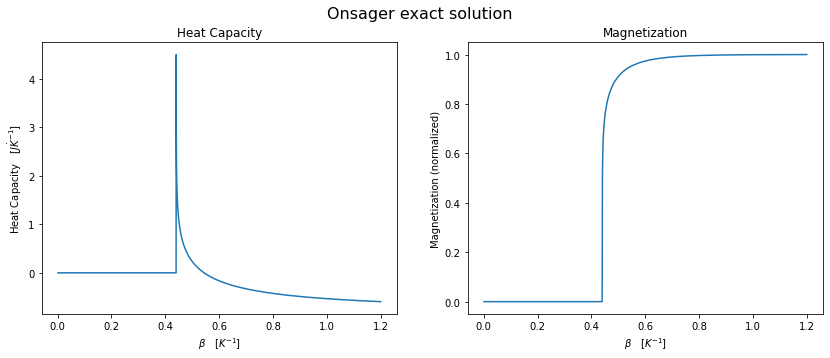

In [6]:
# Plot the Onsager functions:
C, b1 = C_Onsager(int(1e6), BETA_RANGE, J)
m, b2 = mag_Onsager(int(1e6), BETA_RANGE, J)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
ax1.plot(b1,C)
ax1.set(xlabel=r'$\beta \quad [K^{-1}]$', ylabel='Heat Capacity'r'$\quad[ J \dot K^{-1}]$' ,title= 'Heat Capacity')
ax2.plot(b2, m)
ax2.set(xlabel=r'$\beta \quad [K^{-1}]$', ylabel='Magnetization (normalized)' ,title= 'Magnetization')
fig.suptitle('Onsager exact solution', fontsize=16)
plt.show()

## Create Lattice

The function that generate the lattice can be set with a "hot" or a "cold" start:
- **Hot** start set $\sigma_{ij}=+1$ with a given probability $p$ and set $\sigma_{ij}=-1$ with probability $(p-1)$
- **Cold** start set all the spins up

In [7]:
# create a lattice of a given size 
def create_lattice(size=50, start='cold', p_hot=0.75, verbose=True):
    if start == 'cold':
        if verbose: print('cold start')
        lattice = np.ones(shape=(size,size), dtype=np.int32)
    elif start == 'hot':
        if verbose: print('hot start with p(+1) = {}'.format(p_hot))
        lattice = np.random.choice([1,-1],size=(size,size),p=[p_hot,1-p_hot])
        lattice = lattice.astype(np.int32)
    else: 
        print("select start cold or hot")
        
    return lattice


In [8]:
lattice_0 = create_lattice(size=L, start=START, p_hot=P_HOT)

cold start


####Plot Functions (grid, time-evolution)

In [9]:
# Plot the current grid of spin values of the lattice
def plot_grid(lattice, show=True, legend='out', load=None):
    nx = np.shape(lattice)[0]
    ny = np.shape(lattice)[1]
    fig = plt.figure(figsize=(5,5))
    ax = plt.axes()
    plt.imshow(lattice, cmap= 'summer',aspect='equal', vmin=-1, vmax=1)
    ax.set_title('{:d}x{:d} grid'.format(nx,ny), fontsize=14)
    
    plt.xticks(ticks=[])
    plt.yticks(ticks=[])
    
    Up_patch = mpl.patches.Patch(color='#f8fb6c', label='Spin Up')
    Down_patch = mpl.patches.Patch(color='#007e6a', label='Spin Down')
    
    if legend == 'out':
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.8), handles=[Up_patch, Down_patch])
    elif legend == 'in':
        ax.legend(loc='center left', bbox_to_anchor=(0.6, 0.90), handles=[Up_patch, Down_patch], framealpha=0.9 )
    
    if load != None:
        ax.annotate('', xy=(load, -0.05), xycoords='axes fraction', xytext=(0, -0.05), 
            arrowprops=dict(arrowstyle="-|>", color='crimson'))        
    if show:
        plt.show()
    else:
        return ax

In [10]:
# --  Plot a metropolis iteration of energy or magnetization--
def plot_iter(data, name={'energy', 'magnetization'}):
  fig, ax = plt.subplots(1,1, figsize=(7,5))
 
  if data.shape[0]>1e9: 
    oom='Billions'
    scale = 1e9
  elif data.shape[0]>1e6: 
    oom='Millions'
    scale = 1e6
  elif data.shape[0]>1e3: 
    oom='Thousands'
    scale = 1e3
  else: 
    oom='Numbers'
    scale = 1.
  
  ticks = mpl.ticker.FuncFormatter(lambda x, pos: '{:.1f}'.format(x/scale))
  ax.xaxis.set_major_formatter(ticks)
  ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(6))
  ax.set(xlabel='{:s} of iterations'.format(oom))

  if name=='energy':
    ax.set_title('Energy', fontsize=14)
    ax.set(ylabel='Energy [ J ]')   
  
  if name=='magnetization':
    ax.set_title('Magnetiziation', fontsize=14)
    ax.set(ylabel='Magnetization (normalized)')  
  
  ax.plot(data, color='royalblue', linewidth=0.5)

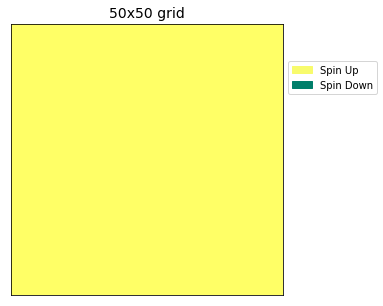

In [11]:
plot_grid(lattice_0)

#### Function for energy computation
The used Hamiltonian is:

$ H = -\frac{1}{2} J \sum_{\langle ij\rangle} \sigma_i \sigma_j $

where the factor $\frac{1}{2}$ avoid double counting.

In [12]:
# Compute system energy for a specific spin configuration
def energy(lattice, J=1):
    Right = np.roll(lattice, 1, 1)
    Left = np.roll(lattice, -1, 1)
    Up = np.roll(lattice, -1, 0)
    Down = np.roll(lattice, 1, 0) 
    Hamiltonian = -0.5*J*np.sum(lattice*Right+lattice*Left+lattice*Up+lattice*Down) # accounting for periodical boundaries
    return Hamiltonian

In [13]:
energy_0 = energy(lattice_0)
print(energy_0)

-5000.0


## Metropolis Algorithm

In [14]:
# Perform the metropolis algorithm
@nb.jit(nb.types.Tuple((nb.int32[:,:], nb.float64[:], nb.float64[:]))(nb.int32[:,:], nb.float64, nb.float64, nb.float64, nb.int64, nb.boolean), nopython=True)
def metropolis(lattice_0, energy_0, beta, J, m_steps=int(1e5), continuous = True):
    
    lattice = lattice_0.copy() 
    L = lattice.shape[0]
    
    energy = np.zeros(m_steps+1)
    energy[0] = energy_0
    
    M = np.zeros(m_steps+1)
    M[0] = np.sum(lattice_0)
    
    for i in range(m_steps):

        #randomly select a spint to flip
        x = np.random.randint(0,L)
        y = np.random.randint(0,L)
        
        left = x-1
        right = x+1
        up = y-1
        down = y+1
        
        # continuous boundary conditions
        if continuous:
            if left < 0: left = L-1
            if right > L-1: right = 0
            if up < 0: up = L-1
            if down > L-1: down = 0

            S = lattice[right, y] + lattice[left, y] + lattice[x, up] + lattice[x, down]

        # non-continuous boundary conditions
        else:           
          if left < 0: pass
          else : S = lattice[left,y]
          if right > L-1: pass
          else: S += lattice[right,y]
          if up < 0: pass
          else: S += lattice[x,up]
          if down > L-1: pass
          else: S += lattice[x,down]

        # difference in energy after spin flip        
        Delta_E = 2*J*lattice[x,y]*S
        p_acc = 0
        
        if Delta_E < 0 :
            p_acc = 1
        else:
            p_acc = np.exp(-Delta_E*beta) # boltzman distribution to check
              
        u = np.random.uniform(0,1) 

        if u < p_acc:
            lattice[x,y] = -lattice[x,y] # change spin
            energy[i+1] = energy[i] + Delta_E # update energy
            M[i+1] = M[i] + 2*lattice[x,y] # update magnetization (using new spin in position x,y)
        else: # no change
            energy[i+1] = energy[i]
            M[i+1] = M[i]
            
    return lattice, energy, M

In [15]:
# perform a metropolis algorithm (call metropolis function)
lattice, en, M = metropolis(lattice_0=lattice_0, energy_0=energy_0, beta=BETA, J=J, m_steps=1e5, continuous=CONTINUOUS)

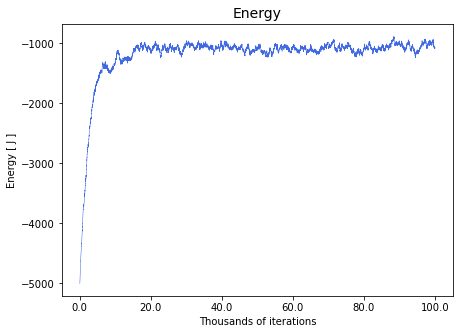

In [16]:
plot_iter(en, name='energy')

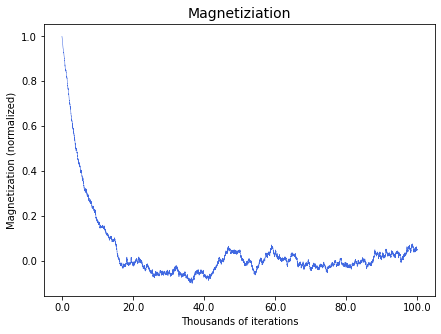

In [17]:
plot_iter(M/(L*L), name='magnetization') # magnetization per spin = total magnetization / L**2

#### GIF function to show lattice evolution

In [18]:
#  GIF for time evolution
import imageio
import os

def gif_metropolis(lattice_0, beta, J, m_steps=int(1e5), continuous=True, name='demo.gif', seconds=5, fps=24):
    
    filenames = []
    time = int(seconds*fps)
    gif_steps = np.rint(np.linspace(0,m_steps, time))
    
    energy_0 = energy(lattice_0)
    
    for i,step in enumerate(gif_steps):
        if i+1 >= len(gif_steps): n_iter = m_steps - gif_steps[i]
        else:                     n_iter = gif_steps[i+1] - gif_steps[i]
        
        lattice, en, M = metropolis(lattice_0=lattice_0, energy_0=energy_0, beta=beta, J=J, m_steps=n_iter, continuous=continuous)
        
        lattice_0 = lattice
        energy_0  = en[-1]
        
        frac = step/m_steps         
        filename = f'{step}.png'
        filenames.append(filename)
        im = plot_grid(lattice, show=False, legend='in', load=frac)
        plt.savefig(filename)
        plt.close()
    
    # build gif
    with imageio.get_writer(name, mode='I', fps=fps) as writer:
        for filename in filenames:
            image = imageio.imread(filename)
            writer.append_data(image)
    # Remove files
    for filename in set(filenames):
        os.remove(filename)

In [19]:
lattice_gif=create_lattice(size=100, start=START, p_hot=P_HOT, verbose=False)
gif_metropolis(lattice_0=lattice_gif, beta=BETA, J=J, m_steps=int(1e5), continuous=True, seconds=20, name='time_evolution.gif', fps=24)

![SegmentLocal](time_evolution.gif "segment")

In [20]:
lattice_gif=create_lattice(size=100, start='hot', p_hot=0.5, verbose=False)
gif_metropolis(lattice_0=lattice_gif, beta=0.55, J=J, m_steps=int(1e5), continuous=True, seconds=20, name='time_evolution_2.gif', fps=24)

![SegmentLocal](time_evolution_2.gif "segment")

# CORRELATION STUDY:

To compute the observables of interest, one should discuss how to sample statistically independent measurements of the energy and magnetization.  
One method is to compute the temporal (successive montecarlo steps) autocorrelation function, that for the magnetization M has the form:  



$G_M(t) = \frac{\overline{M_{n+t}M_n} - \overline{M}^2}{\overline{M^2}-\overline{M}^2}$ where $\overline{M_{n+t}M_n} = \frac{\sum_{n>n_0}^{N-t} M_{n+t}M_n}{N-t-n_0}$


One should expect an exponential decay for the autocorrelation function: 

$G_M(t) ≈ e^{-\frac{t}{\tau}}$ where $\tau$ is the characteristic correlation time of the stochastic process. 

Once $\tau$ has been estimated (from an exponential fit), one can sample statistically independent measurements of magnetization/energy every $\tau$ steps.  




In [21]:
@nb.njit()
def M_corr(M, span_t, n0):
    g_M_arr = np.zeros(len(span_t), dtype=np.float64)
    for i,t in enumerate(span_t):
        
        t = int(t)
        m_samples = M[n0:]
        sum_M_M_t = np.sum(m_samples[:-t] * m_samples[t:])/(len(m_samples)-t)
        M_avg = (m_samples.mean())**2
        M_2_avg = (m_samples**2).mean()

        g_M = (sum_M_M_t - M_avg)/(M_2_avg-M_avg)
        g_M_arr[i] = g_M
    
    
    return g_M_arr

In [22]:
def exp_f(x, tau):
    return np.exp(-x/tau)

In [23]:
def find_tau(span_t, m_corr):
    popt, pcov = optimize.curve_fit(exp_f, span_t, m_corr)
    
    return popt[0], np.sqrt(pcov[0,0])

In [24]:
lattice, en, M = metropolis(lattice_0=lattice_0, energy_0=energy_0, beta=BETA, J=J, m_steps=M_STEPS, continuous=CONTINUOUS)
m_corr = M_corr(M, TAU_RANGE, int(M_STEPS/10))
tau, err = find_tau(TAU_RANGE, m_corr)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

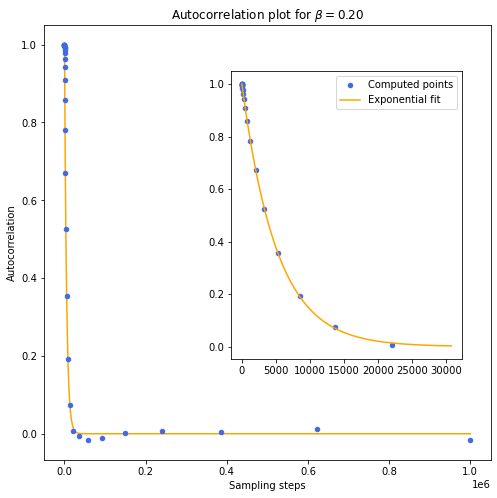

In [25]:
display(Math(r'\tau = {:.0f} \pm {:.0f}'.format(tau, err)))

fig, ax = plt.subplots(1,1, figsize=(8,8))

x = np.linspace(TAU_RANGE[0], TAU_RANGE[-1], int(1e6))

res = m_corr-exp_f(TAU_RANGE, tau)


ssr = np.sum(res**2)
tss = np.sum((np.mean(m_corr)-m_corr)**2)
rsq = 1 - ssr/tss

display(Math(r'R^2 = {:.3f}'.format(rsq)))

ndof = len(TAU_RANGE) - 1 
chi2  = np.sum(res**2)

display(Math(r'\chi^2 \,/ \,ndof =  {:.4f} \,/ \,{:d} = {:.3g}'.format(chi2, ndof, chi2/ndof)))

ax.plot(x, exp_f(x,tau), c='orange', ls = '-', linewidth=1.5, label= 'Exponential fit')
ax.plot(TAU_RANGE, m_corr, c='royalblue', marker='o', ms=4.5,linestyle='--', linewidth=0, label= 'Computed points')
ax.set_xlabel('Sampling steps')
ax.set_ylabel('Autocorrelation')
ax.set_title(r'Autocorrelation plot for $\beta = {:.2f}$'.format(BETA))

mask_zoom = TAU_RANGE<6*tau
mask_zoom_x = x<6*tau
axes = fig.add_axes([0.45, 0.3, 0.4, 0.5])
axes.plot(TAU_RANGE[mask_zoom], m_corr[mask_zoom], c='royalblue', marker='o', ms=4.5,linestyle='--', linewidth=0, label= 'Computed points')
axes.plot(x[mask_zoom_x], exp_f(x[mask_zoom_x],tau), c='orange', ls = '-', linewidth=1.5, label= 'Exponential fit');
axes.legend(loc='upper right');



In [26]:
lattice, en, M = metropolis(lattice_0=lattice_0, energy_0=energy_0, beta=BETA_C, J=J, m_steps=M_STEPS, continuous=CONTINUOUS)
m_corr = M_corr(M, TAU_RANGE, int(M_STEPS/10))
tau, err = find_tau(TAU_RANGE, m_corr)


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

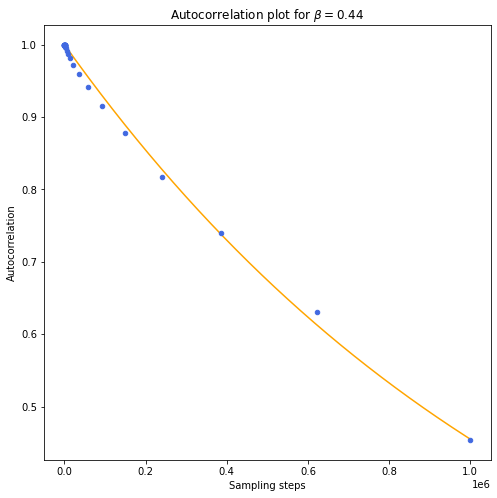

In [27]:
display(Math(r'\tau = {:.2e} \pm {:.2e}'.format(tau, err)))

fig, ax = plt.subplots(1,1, figsize=(8,8))

x = np.linspace(TAU_RANGE[0], TAU_RANGE[-1], int(1e6))

res = m_corr-exp_f(TAU_RANGE, tau)


ssr = np.sum(res**2)
tss = np.sum((np.mean(m_corr)-m_corr)**2)
rsq = 1 - ssr/tss

display(Math(r'R^2 = {:.3f}'.format(rsq)))

ndof = len(TAU_RANGE) - 1 
chi2  = np.sum(res**2)

display(Math(r'\chi^2 \,/ \,ndof =  {:.4f} \,/ \,{:d} = {:.3g}'.format(chi2, ndof, chi2/ndof)))

ax.plot(x, exp_f(x,tau), c='orange', ls = '-', linewidth=1.5, label= 'Exponential fit')
ax.plot(TAU_RANGE, m_corr, c='royalblue', marker='o', ms=4.5,linestyle='--', linewidth=0, label= 'Computed points')
ax.set_xlabel('Sampling steps')
ax.set_ylabel('Autocorrelation')
ax.set_title(r'Autocorrelation plot for $\beta = {:.2f}$'.format(BETA_C));

For a value of $\beta$ near the critical value, one can observe that the correlation time $\tau$ diverges not allowing to sample a sufficient number of points to have significant results. 
To have a better understanding of the phenomenon, one should study the dependency of $\tau$ on $\beta$ 

In [28]:
@nb.jit(parallel=True, nopython=True)
def corr_loop_beta(lattice_0, energy_0, beta_range, tau_range, m_steps, continuous):

    corr_arr = np.zeros((len(beta_range), len(tau_range)))

    for i in nb.prange(len(beta_range)):
        beta = beta_range[i]
        lattice, en, M = metropolis(lattice_0=lattice_0, energy_0=energy_0, beta=beta, J=J, m_steps=m_steps, continuous=continuous)
        m_corr = M_corr(M, tau_range, n0=int(M_STEPS/10))
        corr_arr[i] = m_corr
        
    return corr_arr
      

In [29]:
def tau_vs_beta(lattice_0, energy_0, beta_range, tau_range, m_steps, continuous):
    
    tau_arr_beta = np.zeros(len(beta_range))
    err_tau_arr_beta = np.zeros(len(beta_range))
    corr_arr = corr_loop_beta(lattice_0=lattice_0, energy_0=energy_0, beta_range=beta_range, tau_range=tau_range, m_steps=m_steps, continuous=continuous)

    for i,m_corr in enumerate(corr_arr):
  
        tau, err = find_tau(tau_range, m_corr)
        tau_arr_beta[i] = tau
        err_tau_arr_beta[i] = err        

    return tau_arr_beta, err_tau_arr_beta

In [30]:
tau_arr_beta, err_tau_arr_beta = tau_vs_beta(lattice_0=lattice_0, energy_0=energy_0, beta_range=BETA_RANGE, tau_range=TAU_RANGE, m_steps=M_STEPS, continuous=CONTINUOUS)

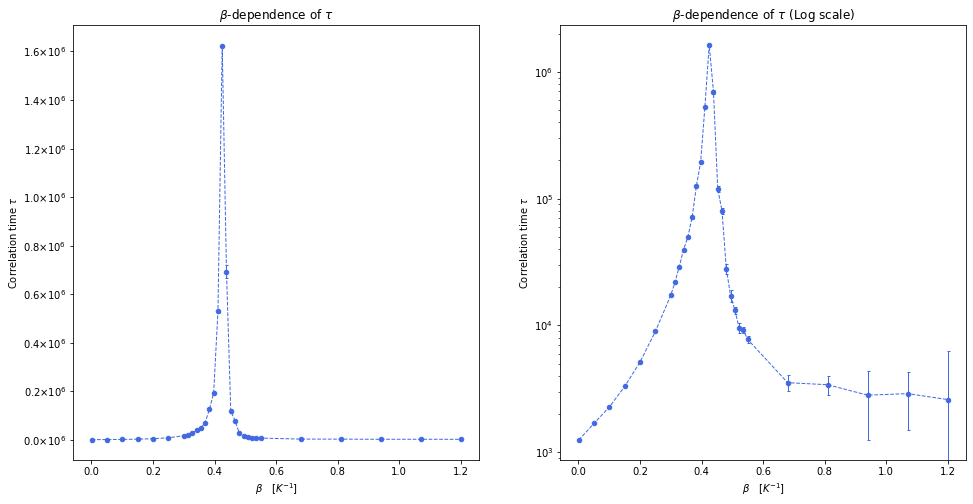

In [31]:
fig, (ax, ax2) = plt.subplots(1,2,figsize=(16,8))
ax.set(xlabel=r'$\beta\quad [K^{-1}]$', ylabel=r'Correlation time $\tau$', title =r'$\beta$-dependence of $\tau$ ')

magnitude = int(np.log10(np.max(tau_arr_beta)))
tau_ticks = mpl.ticker.FuncFormatter(lambda x, pos: r'{:.1f}$\times 10^{}$'.format(x/(10**magnitude), magnitude))
ax.yaxis.set_major_formatter(tau_ticks)

ax.errorbar(BETA_RANGE, tau_arr_beta, yerr=err_tau_arr_beta, color='royalblue', marker='o', ms=4.5, 
                linestyle='--', linewidth=1, capsize=1.5, elinewidth=1, ecolor='royalblue', label='Computed points')

ax2.errorbar(BETA_RANGE, tau_arr_beta, yerr=err_tau_arr_beta, color='royalblue', marker='o', ms=4.5, 
                linestyle='--', linewidth=1, capsize=1.5, elinewidth=1, ecolor='royalblue', label='Computed points')
ax2.set(xlabel=r'$\beta\quad [K^{-1}]$', ylabel=r'Correlation time $\tau$', title =r'$\beta$-dependence of $\tau$ (Log scale)', yscale='log');


It is clear from the plots that when $\beta$ approches the critical value, $\tau$ diverges forcing to increase the number of montecarlo steps required to have statistically independent samples (critical slowing down problem).

One can also study the dependence of $\tau$ on $L$, the system side lenght. One should expect that the correlation time should go as ~$L^2$: a particular system configuration will be uncorrelated from a previous one after enough sites have changed.

Of course, in a 5x5 system this number is lower than in a 50x50 system, for example.

The results obtained below show agreement with this hypothesis

In [32]:
@nb.jit(parallel=True, nopython=True)
def corr_loop_L(lattice_0_arr, energy_0_arr, l_range, beta, J, tau_range, m_steps, continuous):
    
    corr_arr = np.zeros((len(l_range), len(tau_range)))
    
    for i in nb.prange(len(l_range)):
        lattice_0 = lattice_0_arr[i]
        energy_0 = energy_0_arr[i]
        
        lattice, en, M = metropolis(lattice_0=lattice_0, energy_0=energy_0, beta=beta, J=J, m_steps=m_steps, continuous=continuous)
        m_corr = M_corr(M, tau_range, n0=int(M_STEPS/10))
        corr_arr[i] = m_corr
        
    return corr_arr

In [33]:
def tau_vs_L(lattice_0_arr, energy_0_arr, l_range, beta, J, tau_range, m_steps, continuous):
    
    tau_arr_L = np.zeros(len(l_range))
    err_tau_arr_L = np.zeros(len(l_range))
    corr_arr = corr_loop_L(lattice_0_arr=lattice_0_arr, energy_0_arr=energy_0_arr, l_range=l_range, beta=beta, J=J, tau_range=tau_range, m_steps=m_steps, continuous=continuous)
    
    for i,m_corr in enumerate(corr_arr):
  
        tau, err = find_tau(tau_range, m_corr)
        tau_arr_L[i] = tau
        err_tau_arr_L[i] = err

    return tau_arr_L, err_tau_arr_L

In [34]:
lattice_0_arr = nb.typed.List()
[lattice_0_arr.append(create_lattice(size=l, start=START, p_hot=P_HOT, verbose=False)) for l in L_RANGE]
energy_0_arr = nb.typed.List()
[energy_0_arr.append(energy(latt)) for latt in lattice_0_arr]


tau_arr_L, err_tau_arr_L = tau_vs_L(lattice_0_arr=lattice_0_arr, energy_0_arr=energy_0_arr, l_range=L_RANGE, beta=BETA, J=J, tau_range=TAU_RANGE, m_steps=M_STEPS, continuous=CONTINUOUS)


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

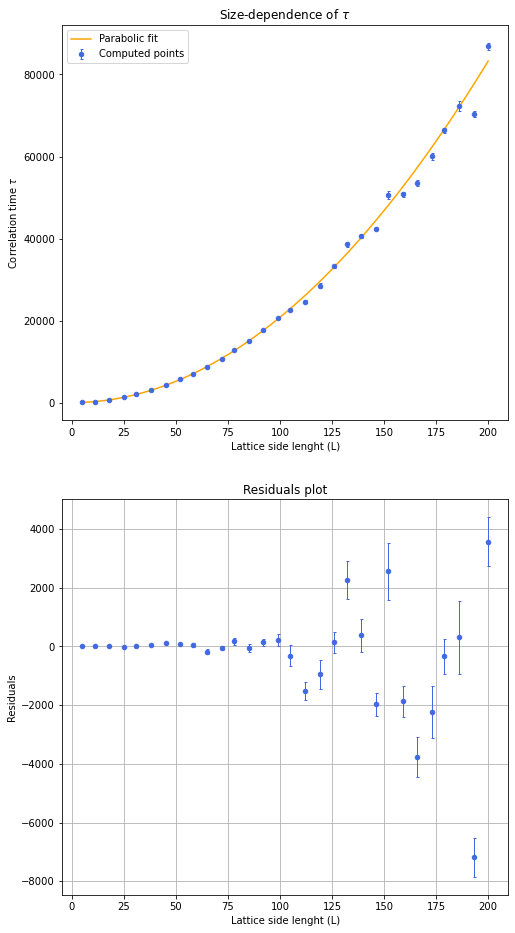

In [35]:
def parabola(x, a, b):
    return a*x**2 + b*x 

x = np.linspace(L_START, L_END, int(1e6))

popt, pcov = optimize.curve_fit(parabola, L_RANGE, tau_arr_L, sigma=err_tau_arr_L, absolute_sigma=True)


display(Math(r'\text{Fit parameters of} \, y= Ax^2 + Bx'))
display(Math(r'A = {:.3f} \pm {:.3f}'.format(popt[0], np.sqrt(pcov[0,0]))))
display(Math(r'B = {:.3f} \pm {:.3f}'.format(popt[1], np.sqrt(pcov[1,1]))))

res = tau_arr_L-(popt[0]*(L_RANGE**2) + popt[1]*(L_RANGE))
res_norm = res/err_tau_arr_L

ssr = np.sum(res**2)
tss = np.sum((np.mean(tau_arr_L)-tau_arr_L)**2)
rsq = 1 - ssr/tss

display(Math(r'R^2 = {:.3f}'.format(rsq)))

ndof = len(L_RANGE) - len(popt) 
chi2  = np.sum(res**2/err_tau_arr_L**2)

display(Math(r'\chi^2 \,/ \,ndof =  {:.3f} \,/ \,{:d} = {:.3f}'.format(chi2, ndof, chi2/ndof)))

y = parabola(x,*popt)

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,16))
ax1.errorbar(L_RANGE, tau_arr_L, yerr=err_tau_arr_L, color='royalblue', marker='o', ms=4.5, 
                linestyle='--', linewidth=0, capsize=1.5, elinewidth=1, ecolor='royalblue', label='Computed points')
#ax.plot(L_RANGE, tau_arr_L, c='royalblue', marker='o', ms=4.5, label='Computed points')
ax1.plot(x, y, c='orange', ls = '-', linewidth=1.5, label='Parabolic fit')
ax1.set(xlabel='Lattice side lenght (L)', ylabel=r'Correlation time $\tau$', title = r'Size-dependence of $\tau$')
ax1.legend()


ax2.errorbar(L_RANGE, res, yerr=err_tau_arr_L, color='royalblue', marker='o', ms=4.5, 
                linestyle='--', linewidth=0, capsize=1.5, elinewidth=1, ecolor='royalblue')
ax2.set(xlabel='Lattice side lenght (L)', ylabel=r'Residuals', title = r'Residuals plot')
ax2.grid()

# OBSERVABLES:

Using the data computed by the ising simulation is possible to obtain information about some properties of the lattice. 

Let's consider the list $M = \lbrace M_1, M_2, \dots, M_n\rbrace$ that represent the magnetizzation (normalized sum of lattice spins) every $\tau$ iteration of the metropolis algorithm (after $t_0$ iteration). In a similar way, let's define $E$ as a list of energies of the system.

It is possible thus to compute the following observables for a lattice of area $L^2$:

Specific heat: $$ C = \beta^2 \frac{\operatorname{var(E)}}{L^2} $$
Magnetic susceptibility: $$\chi = \beta \operatorname{var(M)} $$
Magnetization: $$ M_{avg} = \frac{\langle M \rangle}{L^2} $$

In order to observe a phase transition we have to investigate the behaviour of the sistem for different temperatures. The metropolis simulation was therefore performed for different values of $\beta$ around the expected critical point. 

In [36]:
# Compute kurtosis for variance error
@nb.njit()
def kurtosis(arr):
    fourth_m = np.sum((arr - arr.mean())**4)/len(arr)
    kurt = fourth_m/(arr.var()**2) - 3
    return kurt

In [37]:
# Performs metropolis algorithm for different betas
@nb.jit(nb.types.Tuple((nb.float64[:], nb.float64[:], nb.float64[:], nb.float64[:], nb.float64[:], nb.float64[:]))(nb.int32[:,:], nb.float64, nb.float64[:], nb.float64, nb.int64, nb.float64, nb.boolean), parallel=True, nopython=True)
def ising_vs_beta(lattice_0, energy_0, beta_range, J, m_steps, tau, continuous):
    
    specific_heat = np.zeros(len(beta_range))
    err_specific_heat = np.zeros(len(beta_range))
    susceptibility= np.zeros(len(beta_range))
    err_susceptibility = np.zeros(len(beta_range))
    magnetization = np.zeros(len(beta_range))
    err_magnetization = np.zeros(len(beta_range))
  
  
    n0 = int(m_steps/10.)
    tau = int(tau)

    for i in nb.prange(len(beta_range)):
        
        beta = beta_range[i]
        lattice, en, mag = metropolis(lattice_0=lattice_0, energy_0=energy_0, beta=beta, J=J, m_steps=m_steps, continuous=continuous)
    
        en = en[n0::tau]
        mag = mag[n0::tau]

        specific_heat[i] = beta**2 * en.var() /lattice.shape[0]**2 # Normalized
        err_specific_heat[i] = beta**2*np.sqrt((kurtosis(en) - ((len(en)-3)/(len(en)-1)))* (en.var())**2/len(en)) /lattice.shape[0]**2
        susceptibility[i] = beta * mag.var()
        err_susceptibility[i] = beta*np.sqrt((kurtosis(mag) - ((len(mag)-3)/(len(mag)-1)))* (mag.var())**2/len(mag))
        magnetization[i] = mag.mean()/lattice.shape[0]**2  # Normalized
        err_magnetization[i] = mag.std()/(np.sqrt(len(mag))*lattice.shape[0]**2)



    return specific_heat, err_specific_heat, susceptibility, err_susceptibility, magnetization, err_magnetization

#### Plot function

In [38]:
# Plot the observables in function of beta
def plot_single_ising(data, beta, err, title, ylabel, ax, color_name='royalblue', Onsager=None, J=1.):
  
    ax.axvline(BETA_C, c = 'orange', linestyle = 'dashed', label=r'$\beta_C$')
    if Onsager == 'magnetization':
        m, b = mag_Onsager(int(1e6), beta, J)
        ax.plot(b, m, color='black', label='Onsager solution', alpha=0.8, linewidth=1)
    elif Onsager == 'C':
        C, b = C_Onsager(int(1e6), beta, J)
        ax.plot(b, C, color='black', label='Onsager solution', alpha=0.8, linewidth=1)
        ax.set_ylim(top = np.max(data)*1.3)
  
    ax.errorbar(beta, data, yerr=err, color=color_name, marker='o', ms=4.5, 
                linestyle='--', linewidth=1, capsize=1.5, elinewidth=1, ecolor='black')
    ax.set_title(title)
    ax.set_xlabel(r'$\beta$ 'r'$\left[\frac{1}{K}\right]$')
    ax.set_ylabel(ylabel)
    ax.legend()

### Result
In order to check if there is an high dependence on correlation parameter, the simulation was performed with two different $\tau$ values.

In [39]:
# fix value for tau
TAU_1 = 1e5
TAU_2 = 1e4

In [40]:
s_h, err_s_h, sub, err_sub, mag, err_mag = ising_vs_beta(lattice_0=lattice_0, energy_0=energy_0, beta_range=BETA_RANGE, J=J, m_steps=M_STEPS, tau=TAU_1, continuous=CONTINUOUS)

In [41]:
s_h_2, err_s_h_2, sub_2, err_sub_2, mag_2, err_mag_2 = ising_vs_beta(lattice_0=lattice_0, energy_0=energy_0, beta_range=BETA_RANGE, J=J, m_steps=M_STEPS, tau=TAU_2, continuous=CONTINUOUS)

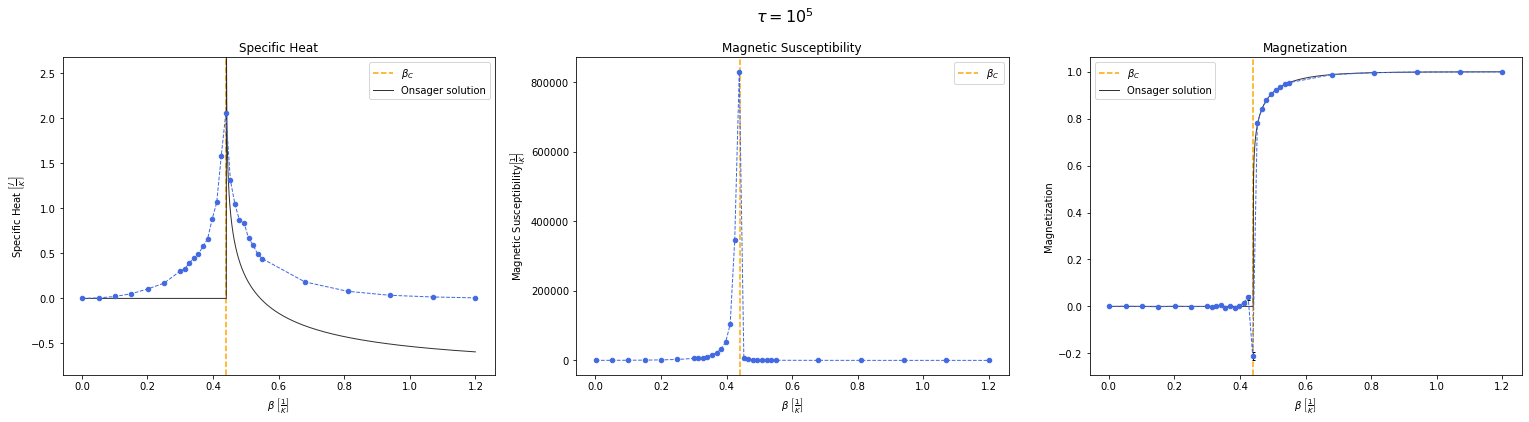

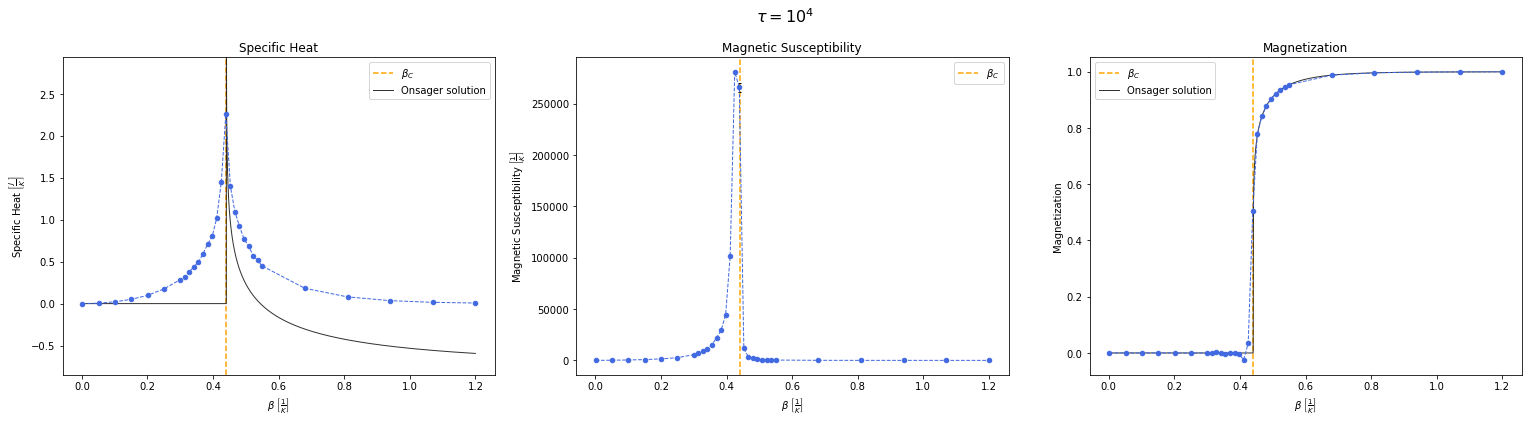

In [42]:
# TAU_1
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(21,5))
fig.tight_layout(w_pad=5, h_pad=5)
fig.suptitle(r'$\tau=10^{}$'.format(int(np.log10(TAU_1))), fontsize=16, y=1.1)
plot_single_ising(s_h, BETA_RANGE, err_s_h, 'Specific Heat', 
                  'Specific Heat 'r'$\left[\frac{J}{K}\right]$', ax1, Onsager='C')
plot_single_ising(sub, BETA_RANGE, err_sub,'Magnetic Susceptibility', 
                  'Magnetic Susceptibility'r'$\left[\frac{1}{K}\right]$', ax2)
plot_single_ising(mag, BETA_RANGE, err_mag, 'Magnetization', 
                  'Magnetization', ax3, Onsager='magnetization')

# TAU_2
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(21,5))
fig.tight_layout(w_pad=5, h_pad=5)
fig.suptitle(r'$\tau=10^{}$'.format(int(np.log10(TAU_2))), fontsize=16, y=1.1)
plot_single_ising(s_h_2, BETA_RANGE, err_s_h_2, 'Specific Heat', 
                  'Specific Heat 'r'$\left[\frac{J}{K}\right]$', ax1, Onsager='C')
plot_single_ising(sub_2, BETA_RANGE, err_sub_2,'Magnetic Susceptibility', 
                  'Magnetic Susceptibility 'r'$\left[\frac{1}{K}\right]$', ax2)
plot_single_ising(mag_2, BETA_RANGE, err_mag_2, 'Magnetization', 
                  'Magnetization', ax3, Onsager='magnetization')

As we can see there are no substancial differences apart from the critical point, where, as we have discuss, thevalue of $\tau$  request to have uncorrelated points diverges. 

It can be instead observated that:
 - Considering the specific heat, the behaviour of the system does not precisely follow the Onsager analytic solution as $C$ grows before the critical $\beta$, too. Futhermore, for values of $\beta$ greater than $\beta_C$ the simulated specific heat tends to zero while the exact solution assume negative values.
 - The magnetic susceptibility $\chi$ have a narrow spike for temperatures equals to or slightly higher than $T_C$, when we indeed expect a high variance of the magnetization due to the phase transition
 - The magnetization have a phase transition that follows the Onsage curve well. Near the critical point we can observe how the simulated system seems to not present a discontinuity in the derivative

# FINITE SIZE ANALYSIS 

In this section we want to analize the impact of a finite size lattice on the magnetic subsceptibility, the specific heat and the magnetization. We did that by computing these observables for various dimension of the lattice from 5x5 to 250x250 using the code below and obtaining the following graphs.

In [43]:
def plot_ising(data, beta, title, ylabel, N, ax, cmap_name='winter_r', Onsager=None):
  
    cmap = plt.get_cmap(cmap_name)
    colors = cmap(np.linspace(0,1,len(data[:,0])))
    
    ax.set_title(title)  
    ax.set_xlabel(r'$\beta$ 'r'$\left[\frac{1}{K}\right]$')
    ax.set_ylabel(ylabel)
    
    ax.axvline(BETA_C, c = 'orange', linestyle = 'dashed', label=r'$\beta_C$', lw=1)
    if Onsager == 'magnetization':
        m, b = mag_Onsager(int(1e6), beta, J)
        ax.plot(b, m, color='black', label='Onsager solution', linewidth=1)
    elif Onsager == 'C':
        C, b = C_Onsager(int(1e6), beta, J)
        ax.plot(b, C, color='black', label='Onsager solution', alpha=0.8)
        ax.set_ylim(top = np.max(data)*1.3)
    
    for i,y in enumerate(data):
        ax.plot(beta, y, color=colors[i], label='{:d} 'r'$\times${:d}'.format(N[i],N[i]), 
                alpha=0.7, marker='o', ms=2.5, linestyle='-', linewidth=1)
         
    ax.legend(title='Grid dimension', loc='center left', bbox_to_anchor=(1, 0.5))

In [44]:
def ising_vs_L(L_range, beta_range, J, m_steps, tau, start='hot', p_hot=0.75, plot = False, continuous=True):
  
    specific_heat = np.zeros((len(L_range), len(beta_range)))
    susceptibility = np.zeros((len(L_range), len(beta_range)))
    magnetization = np.zeros((len(L_range), len(beta_range)))
    
  
    for i,l in tqdm(enumerate(L_range), desc="Dimension analysis", leave=False):
  
        lattice_0 = create_lattice(size=l, start=start, p_hot=p_hot, verbose=False)
        energy_0 = energy(lattice_0)
        s_h, err_s_h, sub, err_sub, mag, err_mag = ising_vs_beta(lattice_0=lattice_0, energy_0=energy_0, beta_range=beta_range, J=J, m_steps=m_steps, tau=tau, continuous=continuous)
    
        specific_heat[i]=s_h
        susceptibility[i]=sub
        magnetization[i]=mag

    if plot:
        fig, ((ax1, ax2), (ax3, ax_none)) = plt.subplots(2,2, figsize=(16,10))
        plot_ising(specific_heat, beta_range, 'Specific Heat', 'Specific Heat'r'$\left[\frac{J}{K}\right]$', L_range, ax1, 'winter_r', Onsager='C')
        plot_ising(susceptibility, beta_range, 'Magnetic Susceptibility', 'Magnetic Susceptibility'r'$\left[\frac{1}{K}\right]$', L_range, ax2, 'autumn_r')
        plot_ising(magnetization, beta_range, 'Magnetization', 'Magnetization', L_range, ax3, 'summer_r', Onsager='magnetization')
        plt.show()

    return specific_heat, susceptibility, magnetization

In [45]:
L_TEST = [5,25,50,100,250]

In [46]:
sp_h, subsc, magn = ising_vs_L(L_TEST, beta_range=BETA_RANGE, J=J, m_steps=M_STEPS, tau=TAU_1, start='hot', p_hot=0.75, continuous=CONTINUOUS)

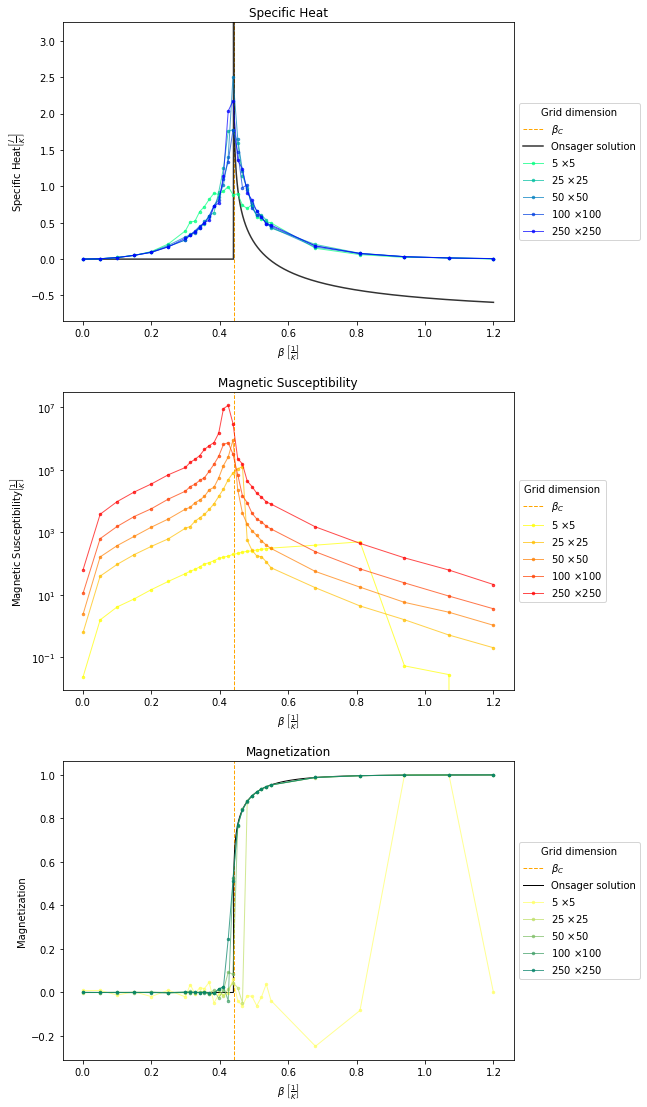

In [47]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(7,15))
fig.tight_layout(h_pad=5)
plot_ising(sp_h, BETA_RANGE, 'Specific Heat', 'Specific Heat'r'$\left[\frac{J}{K}\right]$', L_TEST, ax1, 'winter_r', Onsager='C')
plot_ising(subsc, BETA_RANGE, 'Magnetic Susceptibility', 'Magnetic Susceptibility'r'$\left[\frac{1}{K}\right]$', L_TEST, ax2, 'autumn_r')
plot_ising(magn, BETA_RANGE, 'Magnetization', 'Magnetization', L_TEST, ax3, 'summer_r', Onsager='magnetization')
ax2.set_yscale('log')
plt.show()

CRITICAL EXPONENTS

We can see that by increasing the size of the lattice our points are starting to converge to the exact Onsager solution. In particular the points follow the curve described by the 2D Ising model critical exponents, these curves are: \\
Specific heat: $$ C \propto \left( \frac{1}{\beta}-\frac{1}{\beta_{c}}\right)^{-\alpha} $$
Magnetic susceptibility: $$\chi \propto \left( \frac{1}{\beta}-\frac{1}{\beta_{c}}\right)^{-\gamma} $$
Magnetization: $$ M_{avg} \propto \left( \frac{1}{\beta_{c}}-\frac{1}{\beta}\right)^{\epsilon} $$
Where:
$$ \alpha=0 \\ \gamma=7/4 \\ \epsilon=1/8 $$

In [48]:
BETA_RANGE_MAG = np.geomspace(BETA_C, 0.65, 50)
BETA_RANGE_EXP = np.concatenate((np.linspace(BETA_C-0.05, BETA_C+0.05, 400, endpoint=False), np.linspace(BETA_C+0.005, 0.8, 30)))
SIZE_EXP = 100
lattice_0_exp = create_lattice(size=SIZE_EXP, start='cold')
energy_0_exp =  energy(lattice_0_exp)

cold start


In [49]:
_ , _, _, _, mag, err_mag = ising_vs_beta(lattice_0=lattice_0_exp, energy_0=energy_0_exp, beta_range=BETA_RANGE_MAG, J=J, m_steps=int(1e8), tau=1e6, continuous=CONTINUOUS)

In [50]:
s_h, err_s_h, sub, err_sub, _, _ = ising_vs_beta(lattice_0=lattice_0_exp, energy_0=energy_0_exp, beta_range=BETA_RANGE_EXP, J=J, m_steps=int(1e8), tau=1e6, continuous=CONTINUOUS)

To verify the convergence of our points to the exact solution we fitted the curve for our observables to estimate the value of the corrisponding critical exponent.

MAGNETIZATION

The magnetization fit gives really good results, we dont find any problem by incresing the dimension of the lattice and the critical exponent is converging to 1/8 as expected.

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

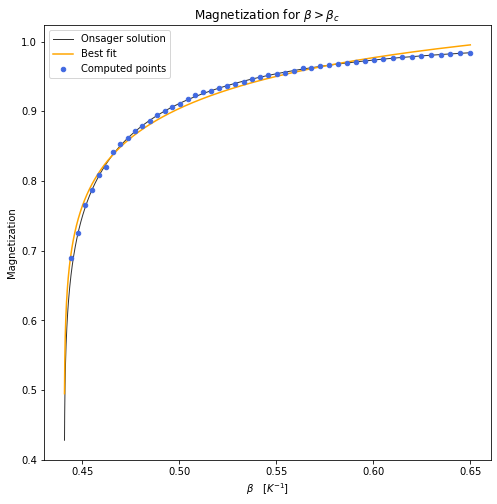

In [56]:
def beta_exp(beta, A, beta_star):
    return A*np.power((1/BETA_C - 1/beta), beta_star)


mask = (BETA_RANGE_MAG>BETA_C)
popt, pcov = optimize.curve_fit(beta_exp, BETA_RANGE_MAG[mask], mag[mask])


# display parameters
   
# plot 
display(Math(r'\beta^* = {:.4f} \pm {:.4f}'.format(popt[1], np.sqrt(pcov[1,1]))))

fig, ax = plt.subplots(1,1, figsize=(8,8))

x = np.linspace(BETA_C+1e-4, 0.65, int(1e6))

res = mag[mask]-beta_exp(BETA_RANGE_MAG[mask],*popt)

ssr = np.sum(res**2)
tss = np.sum((np.mean(mag[mask])-mag[mask])**2)
rsq = 1 - ssr/tss

display(Math(r'R^2 = {:.3f}'.format(rsq)))

ndof = len(BETA_RANGE_MAG[mask]) - 2 
chi2  = np.sum(res**2)

display(Math(r'\chi^2 \,/ \,ndof =  {:.4f} \,/ \,{:d} = {:.3g}'.format(chi2, ndof, chi2/ndof)))


m, b = mag_Onsager(int(1e6), [BETA_C+1e-4, 0.65], J)
ax.plot(b, m, color='black', label='Onsager solution', alpha=0.8, linewidth=1)
ax.plot(x, beta_exp(x,*popt), c='orange', ls = '-', linewidth=1.5, label= 'Best fit')
ax.plot(BETA_RANGE_MAG[mask], mag[mask] , c='royalblue', marker='o', ms=4.5,linestyle='--', linewidth=0, label= 'Computed points')
ax.set_xlabel(r'$\beta\quad [K^{-1}]$')
ax.set_ylabel('Magnetization')
ax.set_title(r'Magnetization for $\beta > \beta_c$ ')
ax.legend();

SPECIFIC HEAT

The specific heat fit is not as accurate as the magnetizion one, we found that by increasing the size of the lattice the point of divergence is not stable at $\beta_{c}$ but it has a random offset which could be eliminated by doing multiple Monte Carlo runs.

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

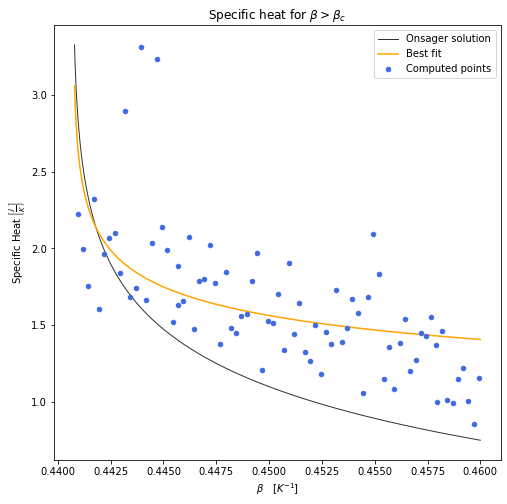

In [57]:
def alpha_exp(beta, A, alpha):
    return A*np.power(np.abs((1/beta - 1/BETA_C)), -alpha)

mask = (BETA_RANGE_EXP > BETA_C ) & (BETA_RANGE_EXP < 0.46)
popt, pcov = optimize.curve_fit(alpha_exp, BETA_RANGE_EXP[mask], s_h[mask])


display(Math(r'\alpha = {:.4f} \pm {:.4f}'.format(popt[1], np.sqrt(pcov[1,1]))))

fig, ax = plt.subplots(1,1, figsize=(8,8))

x = np.linspace(BETA_C+1e-4, 0.46, int(1e6))

res = s_h[mask]-alpha_exp(BETA_RANGE_EXP[mask],*popt)

ssr = np.sum(res**2)
tss = np.sum((np.mean(s_h[mask])-s_h[mask])**2)
rsq = 1 - ssr/tss

display(Math(r'R^2 = {:.3f}'.format(rsq)))

ndof = len(BETA_RANGE_EXP[mask]) - 2 
chi2  = np.sum(res**2)

display(Math(r'\chi^2 \,/ \,ndof =  {:.2f} \,/ \,{:d} = {:.3g}'.format(chi2, ndof, chi2/ndof)))


C, b = C_Onsager(int(1e6), [BETA_C+1e-4, 0.46], J)
ax.plot(b, C, color='black', label='Onsager solution', alpha=0.8, linewidth=1)
ax.plot(x, alpha_exp(x,*popt), c='orange', ls = '-', linewidth=1.5, label= 'Best fit')
ax.plot(BETA_RANGE_EXP[mask], s_h[mask] , c='royalblue', marker='o', ms=4.5,linestyle='--', linewidth=0, label= 'Computed points')
ax.set_xlabel(r'$\beta\quad [K^{-1}]$')
ax.set_ylabel(r'Specific Heat $\left[\frac{J}{K}\right]$')
ax.set_title(r'Specific heat for $\beta > \beta_c$ ')
ax.legend();

MAGNETIC susceptibility

The fit for the magnetic suscettibility couldn't even be done because we can see that by increasing the size of the lattice, hoping that the solution will converge to the Onsager one, only results in a far worse curve than the ones obtained for smaller sizes. This issue could be solved by increasing the number of montecarlo step for the simulation but this was impossible to do beacuse we are limited by our hardware and $10^9$ steps was the maximum our machines could handle without having memory problems and/or long execution times.

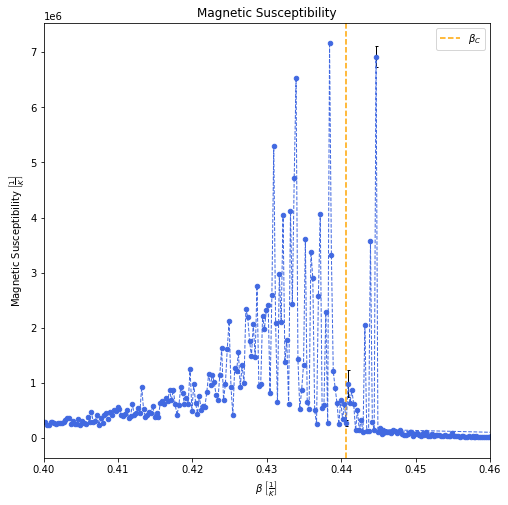

In [53]:
fig, ax2 = plt.subplots(1,1, figsize=(8,8))
plot_single_ising(sub, BETA_RANGE_EXP, err_sub,'Magnetic Susceptibility', 
                  'Magnetic Susceptibility 'r'$\left[\frac{1}{K}\right]$', ax2)
ax2.set_xlim(0.4,0.46);


Below you can see an attempt to fit the suscettibility curve but the results obtained by doing so can't be used because the phase transition peak has a random offset, exactly as the specific heat but even worse. So for the magnetic suscettibility we couldn't come up with a reasonable estimate for the critical exponent.

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

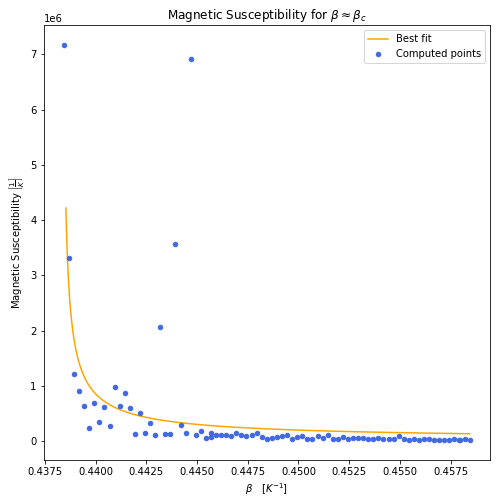

In [58]:
def gamma_exp(beta, A, gamma):
    return A*np.power(np.abs(1/beta - 1/(BETA_RANGE_EXP[np.argmax(sub)]-1e-4)), -gamma)

mask = (BETA_RANGE_EXP >= BETA_RANGE_EXP[np.argmax(sub)]) & (BETA_RANGE_EXP < BETA_RANGE_EXP[np.argmax(sub)]+0.02)
#mask_plot = (BETA_RANGE_EXP > BETA_C-0.02 ) & (BETA_RANGE_EXP < 0.445)
popt, pcov = optimize.curve_fit(gamma_exp, BETA_RANGE_EXP[mask], sub[mask], p0=[1, 7/4])

display(Math(r'\gamma = {:.4f} \pm {:.4f}'.format(popt[1], np.sqrt(pcov[1,1]))))

fig, ax = plt.subplots(1,1, figsize=(8,8))

x = np.linspace(BETA_RANGE_EXP[np.argmax(sub)]+1e-4, BETA_RANGE_EXP[np.argmax(sub)]+0.02, int(1e6))

res = sub[mask]-gamma_exp(BETA_RANGE_EXP[mask],*popt)

ssr = np.sum(res**2)
tss = np.sum((np.mean(sub[mask])-sub[mask])**2)
rsq = 1 - ssr/tss

display(Math(r'R^2 = {:.3f}'.format(rsq)))

ndof = len(BETA_RANGE_EXP[mask]) - 2 
chi2  = np.sum(res**2)

display(Math(r'\chi^2 \,/ \,ndof =  {:.3g} \,/ \,{:d} = {:.3g}'.format(chi2, ndof, chi2/ndof)))


ax.plot(x, gamma_exp(x,*popt), c='orange', ls = '-', linewidth=1.5, label= 'Best fit')
ax.plot(BETA_RANGE_EXP[mask], sub[mask] , c='royalblue', marker='o', ms=4.5,linestyle='--', linewidth=0, label= 'Computed points')
ax.set_xlabel(r'$\beta\quad [K^{-1}]$')
ax.set_ylabel(r'Magnetic Susceptibility $\left[\frac{1}{K}\right]$')
ax.set_title(r'Magnetic Susceptibility for $\beta \approx \beta_c$ ')
ax.legend();

#### References: 
*Books and links used to solve the assigned task*

 - Benjamin A. Stickler, Schaching Ewald. *Basic Concepts in Computational Physics*. Spinger, 2016.
 - Ogilvie Mike. *Monte Carlo, Metropolis and the Ising Model*. 2017
 - Polson Luke. [*The Ising Model in Python*](https://github.com/lukepolson/youtube_channel/blob/main/Python%20Metaphysics%20Series/vid14.ipynb). 2021
 -Leban Jonathan. [*Monte Carlo method applied on a 2D binary alloy using an Ising Model on Python*](https://towardsdatascience.com/monte-carlo-method-applied-on-a-2d-binary-alloy-using-an-ising-model-on-python-70afa03b172b). 2020
 - Orlandini Enzo, Pagano Alice, [*Lecture note of statistical mechanics*](https://github.com/AlicePagano/Lectures-Statistical-Mechanics), 2020